In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE

from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_machine_learning.algorithms import VQC
from IPython.display import clear_output
from sklearn.decomposition import PCA

C:\Users\overm\AppData\Local\Temp\ipykernel_33916\4157023208.py:18: DeprecationWarning: The ``qiskit.opflow`` module is deprecated as of qiskit-terra 0.24.0. It will be removed in Qiskit 1.0. For code migration guidelines, visit https://qisk.it/opflow_migration.
  from qiskit.opflow import PauliSumOp
C:\Users\overm\AppData\Local\Temp\ipykernel_33916\4157023208.py:22: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed in Qiskit 1.0. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.optimizers import COBYLA


In [3]:
# Load dataset
df = pd.read_csv('D:/ergnerg/Kuliah/Semester 6/Komputasi Kuantum/UAS/email.csv')
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5573 entries, 0 to 5572
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5573 non-null   object
 1   Message   5573 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


Category    0
Message     0
dtype: int64

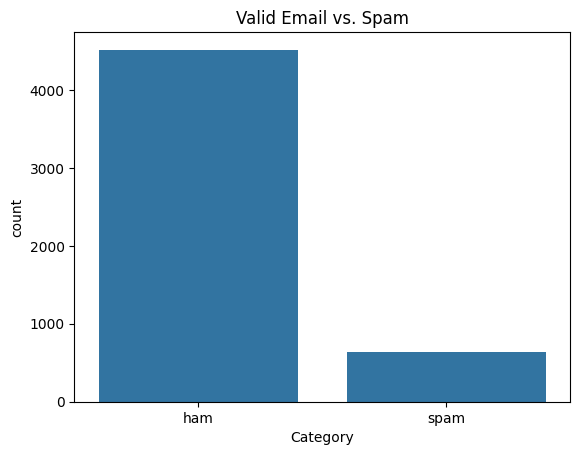

Jumlah Spam:  641
Jumlah Bukan Spam:  4516


In [5]:
# Drop duplicates
df.drop_duplicates(inplace=True)

# Remove the last row if needed
df = df.head(-1)

sns.countplot(x='Category', data=df)
plt.title('Valid Email vs. Spam')
plt.show()

# Menghitung jumlah spam dan bukan spam
label_counts = df['Category'].value_counts()

print("Jumlah Spam: ", label_counts['spam'])
print("Jumlah Bukan Spam: ", label_counts['ham'])

In [6]:
# Split data into x (messages) and y (categories)
x = df['Message']
y = df['Category'].apply(lambda x: 1 if x == 'spam' else 0)  # Convert labels to binary values

# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [7]:
# Menggunakan TF-IDF Vectorizer
vectorizer = TfidfVectorizer()
x_train_tfidf = vectorizer.fit_transform(x_train).toarray()
x_test_tfidf = vectorizer.transform(x_test).toarray()

In [8]:
# Menggunakan SMOTE untuk oversampling
smote = SMOTE(random_state=42)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train_tfidf, y_train)

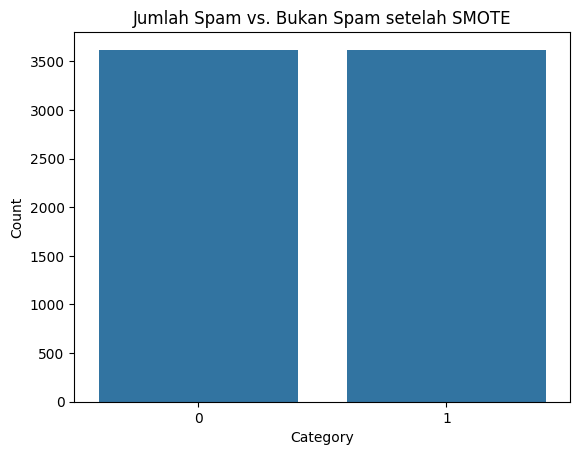

In [17]:
# Konstruksi DataFrame dari data yang telah di-resample
resampled_df = pd.DataFrame(x_train_resampled, columns=vectorizer.get_feature_names_out())
resampled_df['Category'] = y_train_resampled

# Plot jumlah Spam vs. Bukan Spam setelah SMOTE
sns.countplot(x='Category', data=resampled_df)
plt.title('Jumlah Spam vs. Bukan Spam setelah SMOTE')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

In [9]:
# Pengurangan fitur menggunakan PCA
pca = PCA(n_components=4)
X_train_pca = pca.fit_transform(x_train_resampled)
X_test_pca = pca.transform(x_test_tfidf)

In [10]:
# Ofv
objective_func_vals = []
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [11]:
# Create and train the VQC model
# Parameter
backend          = Aer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend)
optimizer        = COBYLA(maxiter=100)
num_qubits       = 4

# Encoding-Ansatz
feature_map = ZZFeatureMap(feature_dimension=num_qubits, reps=2)
ansatz      = RealAmplitudes(num_qubits=num_qubits, reps=2)

# Vqc
vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph
)

C:\Users\overm\AppData\Local\Temp\ipykernel_33916\1978389505.py:3: DeprecationWarning: The 'qiskit.Aer' entry point is deprecated and will be removed in Qiskit 1.0. You should use 'qiskit_aer.Aer' directly instead.
  backend          = Aer.get_backend('qasm_simulator')
C:\Users\overm\AppData\Local\Temp\ipykernel_33916\1978389505.py:4: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed in the Qiskit 1.0 release. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend)


In [13]:
# Convert y_train_resampled to numpy array
y_train_resampled_np = y_train_resampled.values

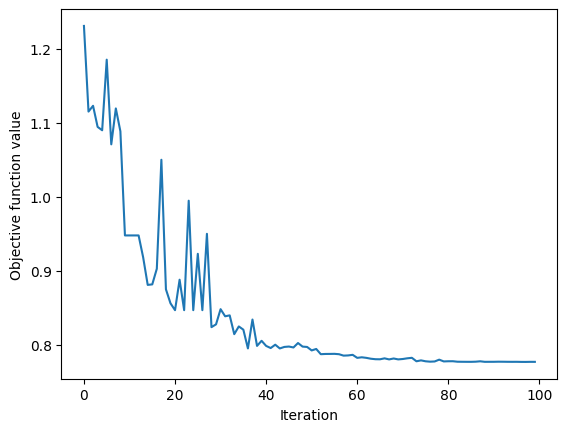

In [14]:
vqc.fit(X_train_pca, y_train_resampled_np)

In [16]:
y_pred_tr = vqc.predict(X_train_pca)
y_pred_ts = vqc.predict(X_test_pca)

acc_tr = np.round(accuracy_score(y_train_resampled_np, y_pred_tr), 3)
acc_ts = np.round(accuracy_score(y_test, y_pred_ts), 3)
print("Accuracy Train :", acc_tr)
print("Accuracy Test  :", acc_ts)

Accuracy Train : 0.746
Accuracy Test  : 0.819
